# Diagnose C Matrix Validity

Check if the training data produces valid right Cauchy-Green tensors when using C = I + 2E.

For a valid deformation, C must be positive definite, which means det(C) > 0.

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import tensorflow as tf
from src.data import load_dataset, prepare_data
from src.models.pann_model import PANNModel

/Users/juanaguila/Code/neohookean-ml-pipeline/keras_env/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# Load data
data_path = '../../neohookean-data-generator/data/consolidated_all.npz'
dataset = load_dataset(data_path)
print(f"Loaded {dataset['n_samples']} samples")

Loaded 15925 samples


In [3]:
# Prepare training data
data = prepare_data(
    dataset['strains'],
    dataset['stresses'],
    random_state=42,
    scale=False  # PANN uses physical values
)

print(f"Train: {data['splits']['train']}, Val: {data['splits']['val']}, Test: {data['splits']['test']}")

Train: 9555, Val: 3185, Test: 3185


## Compute C from Training Strains

In [4]:
# X_train is (N,3): [E11, E22, gamma12]
X = tf.convert_to_tensor(data["X_train"], dtype=tf.float64)
C = PANNModel.E_voigt_to_C(X)

print(f"C shape: {C.shape}")
print(f"C dtype: {C.dtype}")

C shape: (9555, 3, 3)
C dtype: <dtype: 'float64'>


## Check Symmetry and Compute Determinant

In [5]:
# Symmetrize (should already be symmetric, but enforce it)
C_sym = 0.5 * (C + tf.linalg.matrix_transpose(C))

# Check if symmetrization made a difference
max_asym = float(tf.reduce_max(tf.abs(C - C_sym)))
print(f"Max asymmetry: {max_asym:.2e}")

Max asymmetry: 0.00e+00


In [6]:
# Compute det via plane strain formula: det(C) = C11*C22 - C12^2
# (since C13=C23=0 and C33=1 for plane strain)
C11 = C_sym[:, 0, 0]
C22 = C_sym[:, 1, 1]
C12 = C_sym[:, 0, 1]
C33 = C_sym[:, 2, 2]

# Full determinant for plane strain: det(C) = C33 * (C11*C22 - C12^2)
I3 = C33 * (C11 * C22 - C12 * C12)

print(f"\nC33 statistics:")
print(f"  min: {float(tf.reduce_min(C33)):.6f}")
print(f"  max: {float(tf.reduce_max(C33)):.6f}")
print(f"  mean: {float(tf.reduce_mean(C33)):.6f}")


C33 statistics:
  min: 1.000000
  max: 1.000000
  mean: 1.000000


## Analyze I3 (det C)

In [7]:
print("\nI3 = det(C) statistics:")
print(f"  min:  {float(tf.reduce_min(I3)):.6e}")
print(f"  max:  {float(tf.reduce_max(I3)):.6e}")
print(f"  mean: {float(tf.reduce_mean(I3)):.6e}")
print(f"  std:  {float(tf.math.reduce_std(I3)):.6e}")

# Check for invalid values
n_negative = float(tf.reduce_sum(tf.cast(I3 < 0, tf.float64)))
n_zero = float(tf.reduce_sum(tf.cast(tf.abs(I3) < 1e-12, tf.float64)))
n_total = len(I3)

print(f"\nValidity check:")
print(f"  Total samples: {n_total}")
print(f"  I3 < 0:  {int(n_negative)} ({100*n_negative/n_total:.2f}%)")
print(f"  I3 ≈ 0:  {int(n_zero)} ({100*n_zero/n_total:.2f}%)")
print(f"  I3 > 0:  {int(n_total - n_negative - n_zero)} ({100*(n_total-n_negative-n_zero)/n_total:.2f}%)")


I3 = det(C) statistics:
  min:  4.169854e-01
  max:  2.310660e+00
  mean: 1.006187e+00
  std:  2.344046e-01

Validity check:
  Total samples: 9555
  I3 < 0:  0 (0.00%)
  I3 ≈ 0:  0 (0.00%)
  I3 > 0:  9555 (100.00%)


In [8]:
# Fraction with invalid determinant
fraction_invalid = float(tf.reduce_mean(tf.cast(I3 <= 0, tf.float64)))
print(f"\n{'='*60}")
print(f"RESULT: {100*fraction_invalid:.2f}% of samples have I3 ≤ 0")
print(f"{'='*60}")

if fraction_invalid > 0.01:
    print("\n⚠️  WARNING: Significant fraction of invalid C matrices!")
    print("   This means C = I + 2E produces non-physical deformations.")
    print("   Possible causes:")
    print("   - Data uses different strain measure (not Green-Lagrange)")
    print("   - Very large strains causing numerical issues")
    print("   - Need to filter invalid samples from training data")
else:
    print("\n✓ Data is compatible with C = I + 2E formulation")


RESULT: 0.00% of samples have I3 ≤ 0

✓ Data is compatible with C = I + 2E formulation


## Visualize I3 Distribution

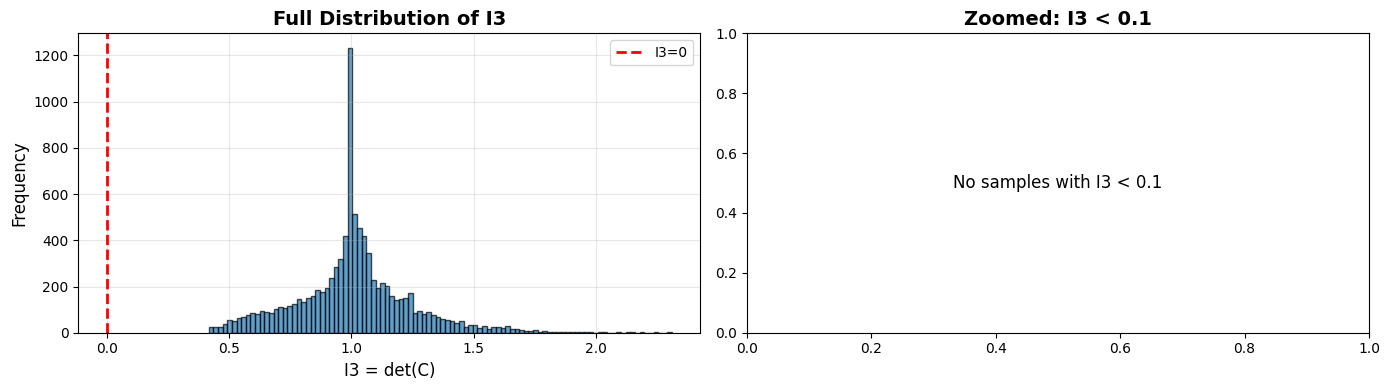

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Full distribution
I3_np = I3.numpy()
axes[0].hist(I3_np, bins=100, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='I3=0')
axes[0].set_xlabel('I3 = det(C)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Full Distribution of I3', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Zoom on problematic region
I3_near_zero = I3_np[I3_np < 0.1]
if len(I3_near_zero) > 0:
    axes[1].hist(I3_near_zero, bins=50, edgecolor='black', alpha=0.7, color='coral')
    axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='I3=0')
    axes[1].set_xlabel('I3 = det(C)', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Zoomed: I3 < 0.1', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'No samples with I3 < 0.1', 
                ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
    axes[1].set_title('Zoomed: I3 < 0.1', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Check Individual Strain Components

In [10]:
# Look at samples with negative I3
invalid_mask = I3 <= 0
n_invalid = int(tf.reduce_sum(tf.cast(invalid_mask, tf.int32)))

if n_invalid > 0:
    print(f"\nAnalyzing {n_invalid} invalid samples:")
    
    E_invalid = data["X_train"][invalid_mask.numpy()]
    
    print("\nStrain statistics for invalid samples:")
    print(f"  E11: min={E_invalid[:,0].min():.4f}, max={E_invalid[:,0].max():.4f}, mean={E_invalid[:,0].mean():.4f}")
    print(f"  E22: min={E_invalid[:,1].min():.4f}, max={E_invalid[:,1].max():.4f}, mean={E_invalid[:,1].mean():.4f}")
    print(f"  γ12: min={E_invalid[:,2].min():.4f}, max={E_invalid[:,2].max():.4f}, mean={E_invalid[:,2].mean():.4f}")
    
    print("\nStrain statistics for ALL samples:")
    E_all = data["X_train"]
    print(f"  E11: min={E_all[:,0].min():.4f}, max={E_all[:,0].max():.4f}, mean={E_all[:,0].mean():.4f}")
    print(f"  E22: min={E_all[:,1].min():.4f}, max={E_all[:,1].max():.4f}, mean={E_all[:,1].mean():.4f}")
    print(f"  γ12: min={E_all[:,2].min():.4f}, max={E_all[:,2].max():.4f}, mean={E_all[:,2].mean():.4f}")
else:
    print("\n✓ All samples produce valid C matrices")


✓ All samples produce valid C matrices
